# Качество патронов

При стрельбе по мишени качество патронов влияет на точность попаданий.

Патроны из одной партии неодинаковы. Например, может отличаться количество пороха из-за погрешности на производстве. Чем сильнее отличаются патроны, тем больше разброс попаданий на мишени.

**Цель:** хотим в среднем набирать как можно больше очков.

**Очки** начисляются за попадание в круги на мишени. Центры кругов совпадают, их диаметры: 5см, 10см, ..., 50см. За попадание в круг диаметра 5см дают 10 очков, за попадание между кругами диаметров 5см и 10см - 9 очков и так далее. Если не попал в круг диаметром 50см, то 0 очков.

**Bias-Variance:** при выборе патронов нам важен именно характер разброса, а не абсолютная близость попаданий к центру мишени во время эксперимента. Смещение стрелок сможет убрать позже, скорректировав прицельное приспособление. С разбросом так сделать не получится. Ситуация на нижней левой картинке для нас намного лучше, чем ситуация на правой верхней картинке.

<img src="https://www.cs.cornell.edu/courses/cs4780/2023fa/lectures/images/bias_variance/bullseye.png"  width="500">

**Эксперимент:** пришло две партии патронов от разных заводов, хотим определить какая лучше и есть ли статистически значимые отличия. Делаем по 100 выстрелов патронами из каждой партии. Получаем два набора данных, в каждом 100 пар координат (x, y) относительно центра мишени.

**Предположения:**
- Выстрелы считаем независимыми друг от друга;
- Отличия в характере разброса попаданий обусловлено только качеством патронов;
- Разброс попаданий симметричен относительно центра. Не будем рассматривать ситуации, когда есть выбросы в одну сторону.

В задании вам предстоит подумать над выбором метрик для оценки эксперимента, исследовать корректность работы разных способов оценки, выбрать наиболее подходящий и принять решение по данным конкретного эксперимента.

### Задание 1 (1 балл). Метрики

Предлагаем рассмотреть две метрики, характеризующие разброс попаданий:
- среднее расстояние от попаданий до центра, где центр вычисляется как среднее координат попаданий;
- среднее количество очков на мишени, которое заработал бы стрелок, если центр попаданий совпадал бы с центром мишени.

Напишите функции, которые помогут вычислять метрики эксперимента: `get_distances` и `get_scores`.


In [4]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
def get_distances(points):
    """Вычисляет расстояния от точек до их центра.

    :points (np.array): массив размера (N, 2) c координатами N точек
    :return (np.array): массив размера N.
    """
    means_ = np.mean(points, axis=0)
    return np.sum((points - means_)**2, axis=1)**0.5

np.testing.assert_almost_equal(
    np.array([1, 1]),
    get_distances(np.array([[0, 0], [0, 2]])),
)
np.testing.assert_almost_equal(
    np.array([1.6666667, 0.33333333, 1.94365063]),
    get_distances(np.array([[0, 0], [-1, -1], [-3, -2]])),
)
print('тесты пройдены')

тесты пройдены


In [3]:
def get_scores(distances):
    """Вычисляет очки по расстояниям до центра мишени.

    :distances (np.array): массив размера N c расстояниями до центра мишени
    :return (np.array): массив размера N с количеством очков за попадания
    """
    scores = 10 - distances // 5
    scores[scores <= 0] = 0
    return scores


np.testing.assert_almost_equal(
    np.array([10, 10,  9,  8,  7,  6,  5,  5,  4,  3,  2,  1,  0]),
    get_scores(np.linspace(0, 51, 13)),
)
print('тесты пройдены')

тесты пройдены


### Задание 2 (3 балла). Численные эксперименты

Согласно описанным выше метрикам проверяем гипотезу о равенстве средних. Рассмотрите **три подхода** для проверки гипотезы: t-test, бутстреп, собственный критерий на основе исторических данных. Для построения собственного критерия используйте данные о 1 млн выстрелов.

Данные генерируйте функцией `np.random.multivariate_normal((0, 0), ((var, 0), (0, var)))`. Для групп без эффекта используйте `var=200`, для экспериментов с эффектом рассмотрите **два случая**: `var=150` и `var=250`.

Для бутстрепа оценивайте вероятности ошибок, для остальных тестов постройте распределения p-value.
Уровень значимости $\alpha=0.05$. Размер групп 10. Если критерий будет работать некорректно, попробуйте увеличить размер групп до 100.

Итого, нужно написать код, который оценивает вероятности ошибок и строит распределения p-value для комбинаций следующих параметров:
- две метрики;
- три критерия;
- синтетические АА тесты и два варианта АB тестов;
- два размера групп.

### T-TEST

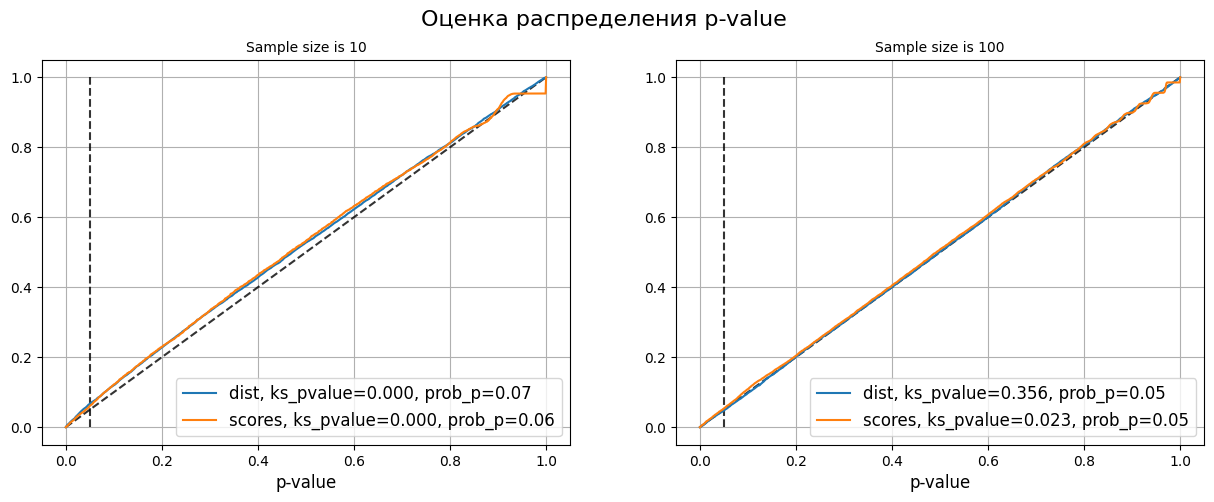

In [20]:
sample_sizes = [10, 100]
n_iter = 10**4
var = 200
alpha = 0.05
dict_metrics = {
    'dist': lambda points: get_distances(points),
    'scores': lambda points: get_scores(get_distances(points))
}

X = np.linspace(0, 1, 1000)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, sample_size in enumerate(sample_sizes):
    axes[i].set_title(f'Sample size is {sample_size}', size=10)
    axes[i].set_xlabel('p-value', size=12)
    axes[i].plot([0, 1], [0, 1], '--k', alpha=0.8)
    axes[i].plot([alpha, alpha], [0, 1], '--k', alpha=0.8)
    for name, metric in dict_metrics.items():
        pvalues = []
        for _ in range(n_iter):
            a, b = np.random.multivariate_normal((0, 0), ((var, 0), (0, var)), (2, sample_size))
            pvalues.append(stats.ttest_ind(metric(a), metric(b)).pvalue)
    
        Y = [np.mean(pvalues <= x) for x in X]
        ks_pvalue = stats.ks_1samp(pvalues, lambda x: np.clip(x, 0, 1)).pvalue
        prob_p = np.mean(np.array(pvalues) < alpha)
        axes[i].plot(X, Y, label=f'{name}, ks_pvalue={ks_pvalue:0.3f}, prob_p={prob_p:0.2f}')
    axes[i].legend(fontsize=12)
    axes[i].grid()

fig.suptitle('Оценка распределения p-value', fontsize=16)
plt.show()

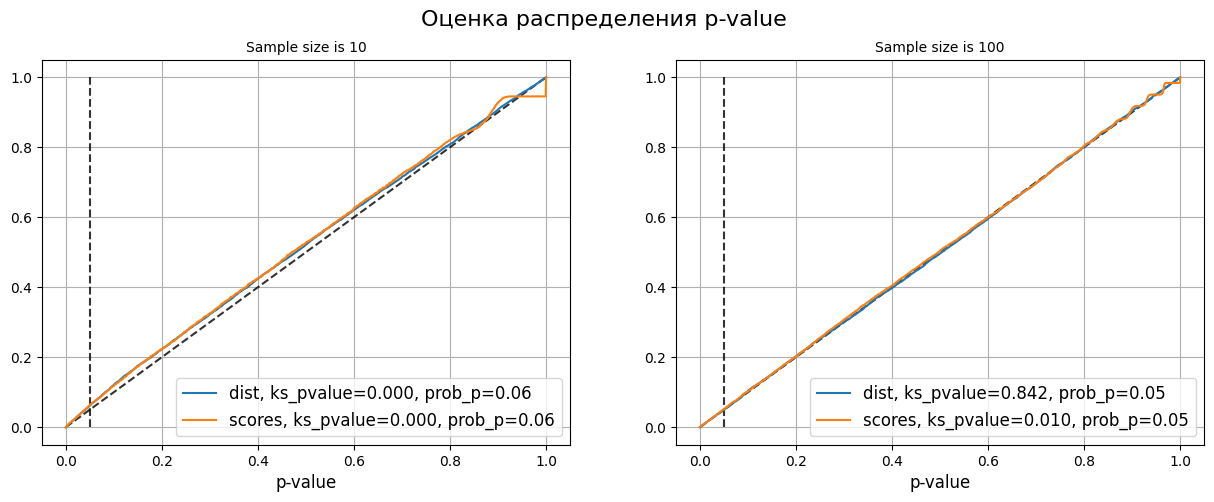

In [22]:
var = 150
effect = 25

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, sample_size in enumerate(sample_sizes):
    axes[i].set_title(f'Sample size is {sample_size}', size=10)
    axes[i].set_xlabel('p-value', size=12)
    axes[i].plot([0, 1], [0, 1], '--k', alpha=0.8)
    axes[i].plot([alpha, alpha], [0, 1], '--k', alpha=0.8)
    for name, metric in dict_metrics.items():
        pvalues = []
        for _ in range(n_iter):
            a, b = np.random.multivariate_normal((0, 0), ((var, 0), (0, var)), (2, sample_size))
            pvalues.append(stats.ttest_ind(metric(a), metric(b + effect)).pvalue)
    
        Y = [np.mean(pvalues <= x) for x in X]
        ks_pvalue = stats.ks_1samp(pvalues, lambda x: np.clip(x, 0, 1)).pvalue
        prob_p = np.mean(np.array(pvalues) < alpha)
        axes[i].plot(X, Y, label=f'{name}, ks_pvalue={ks_pvalue:0.3f}, prob_p={prob_p:0.2f}')
    axes[i].legend(fontsize=12)
    axes[i].grid()

fig.suptitle('Оценка распределения p-value', fontsize=16)
plt.show()

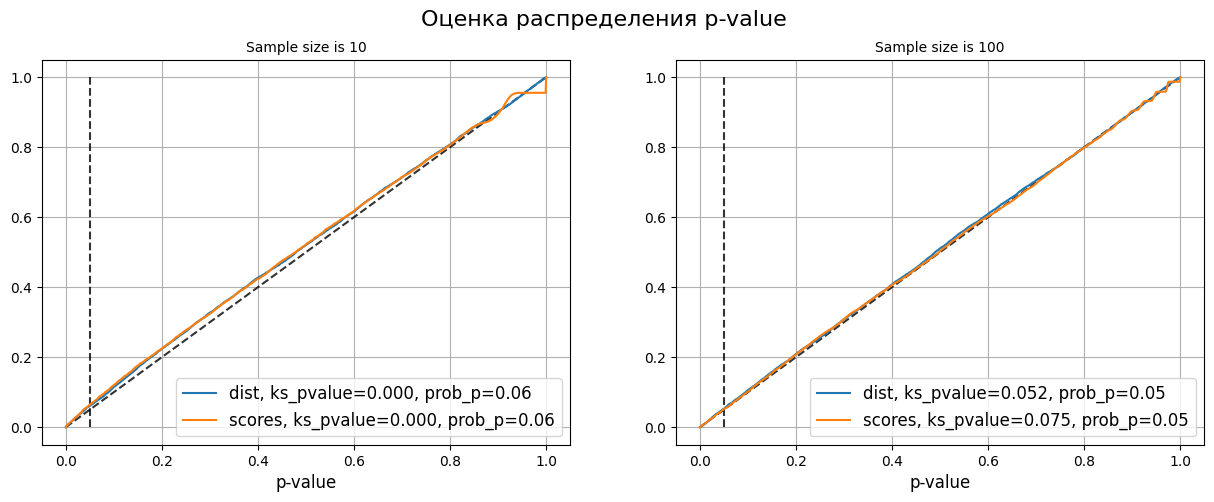

In [23]:
var = 250
effect = 25

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, sample_size in enumerate(sample_sizes):
    axes[i].set_title(f'Sample size is {sample_size}', size=10)
    axes[i].set_xlabel('p-value', size=12)
    axes[i].plot([0, 1], [0, 1], '--k', alpha=0.8)
    axes[i].plot([alpha, alpha], [0, 1], '--k', alpha=0.8)
    for name, metric in dict_metrics.items():
        pvalues = []
        for _ in range(n_iter):
            a, b = np.random.multivariate_normal((0, 0), ((var, 0), (0, var)), (2, sample_size))
            pvalues.append(stats.ttest_ind(metric(a), metric(b + effect)).pvalue)
    
        Y = [np.mean(pvalues <= x) for x in X]
        ks_pvalue = stats.ks_1samp(pvalues, lambda x: np.clip(x, 0, 1)).pvalue
        prob_p = np.mean(np.array(pvalues) < alpha)
        axes[i].plot(X, Y, label=f'{name}, ks_pvalue={ks_pvalue:0.3f}, prob_p={prob_p:0.2f}')
    axes[i].legend(fontsize=12)
    axes[i].grid()

fig.suptitle('Оценка распределения p-value', fontsize=16)
plt.show()

### Bootstrap

In [ ]:
def get_normal_ci(bootstrap_stats, pe, alpha):
    """Строит нормальный доверительный интервал.

    bootstrap_stats - бутстрепные оценки
    pe - точечная оценка
    alpha - уровень значимости

    return: границы ДИ
    """
    z = stats.norm.ppf(1 - alpha / 2)
    se = np.std(bootstrap_stats)
    left, right = pe - z * se, pe + z * se
    return left, right

def get_percentile_ci(bootstrap_stats, pe, alpha):
    """Строит перцентильный доверительный интервал.

    bootstrap_stats - бутстрепные оценки
    pe - точечная оценка
    alpha - уровень значимости

    return: границы ДИ
    """
    left, right = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    return left, right

def get_pivotal_ci(bootstrap_stats, pe, alpha):
    """Строит центральный доверительный интервал.

    bootstrap_stats - бутстрепные оценки
    pe - точечная оценка
    alpha - уровень значимости

    return: границы ДИ
    """
    left, right = 2 * pe - np.quantile(bootstrap_stats, [1 - alpha / 2,  alpha / 2])
    return left, right

B = 10000

In [ ]:
dict_functions = {
    'mean': lambda x: np.mean(x, axis=1),
}
var = 200
dict_res = defaultdict(list)
for _ in range(n_iter):
    a, b = np.random.multivariate_normal((0, 0), ((var, 0), (0, var)), (2, sample_size))
    for func_name, func in dict_functions.items():
        pe = func([b])[0] - func([a])[0]
        bootstrap_stats = (
            func(np.random.choice(b, (B, n)))
            - func(np.random.choice(a, (B, n)))
        )
        for ci_name, get_ci in dict_ci_methods.items():
            ci = get_ci(bootstrap_stats, pe, alpha)
            res = 1 - int(ci[0] < 0 < ci[1])
            dict_res[f'stat_{func_name} ci_{ci_name}'].append(res)

print_bernoulli_ci(dict_res)

### Задание 3 (2 балла). Анализ численных экспериментов.

Напишите свои мысли по следующим вопросам:

**Блок 1:**
- Какие критерии для каких метрик контролируют вероятность ошибки первого рода на заданном уровне при размере групп равным 10?
- Если вероятность ошибки первого рода не контролируется, то почему это может происходить? Какие предположения нарушены?
- Помогло ли увеличение размера групп получить контроль над вероятностью ошибок первого рода?

**Блок 2:**
- Какие особенности в распределениях p-value наблюдаются? Чем они вызваны?
- Какая из двух метрик имеет большую мощность? Как думаете, почему это так?
- Для синтетических АB экспериментов рассматривалось два варианта эффекта $200\pm50$. Мощности критериев для этих вариантов отличаются? Если да, то почему?

Судя по полученным результатам, метод Scores справляется лучше. При метрике-расстоянии t-test справлялся хуже, не нашел разницу в средних. Хотя зависит от эффекта и масштаба самих сэмплов.

### Задание 4 (2 балла). Дизайн эксперимента

По-хорошему нужно фиксировать все параметры эксперимента до его запуска. Опираясь на результаты численных экспериментов, определите что и как будете оценивать в эксперименте. Обоснуйте свой выбор.

- какая метрика?
- какой критерий?
- какой размер групп, 10 или 100?
- как будет приниматься решение? В итоге нужно сказать есть ли значимые отличия патронов из группы B. При каких условиях скажем, что они значимо лучше? При каких условиях скажем, что они значимо хуже?

### Задание 5 (2 балла). Оценка эксперимента

Ниже приведены данные эксперимента. Проверьте для каждой из метрик какая серия выстрелов лучше и есть ли статистически значимые отличия. Есть ли в этих результатах что-то необычное? Объяснить получившийся результат.

Какие патроны в итоге будем использовать в дальнейшем?

In [ ]:
a = np.array([[-5.866, -4.715], [1.147, -11.187], [-3.091, -10.793], [-10.99, 26.154], [-9.979, -1.217], [4.072, -1.858], [-13.898, -12.994], [16.963, -4.828], [-24.87, 0.723], [-8.088, -9.907], [-13.224, 21.701], [27.965, -6.154], [-1.903, -2.964], [-10.845, 0.565], [8.652, -3.731], [7.315, 9.711], [15.563, -1.303], [-5.893, -3.109], [-0.251, -16.834], [-15.353, -15.202], [0.203, -1.261], [-9.549, 22.481], [-6.328, -7.363], [-9.809, 17.943], [19.805, -8.81], [5.467, 8.047], [-20.176, -25.893], [-21.986, 34.126], [3.257, 3.638], [-3.079, -7.312], [25.643, -12.654], [3.736, 32.391], [-5.356, -1.713], [-5.216, -17.179], [-3.341, 17.842], [-4.65, 0.408], [-18.106, -34.23], [14.179, -21.627], [-7.998, -6.178], [20.697, -19.382], [10.831, -29.149], [9.675, 14.98], [2.55, 3.798], [1.543, 12.509], [-9.679, 36.311], [-8.324, -3.295], [-4.522, -2.125], [-12.494, -7.173], [-27.934, -33.084], [-22.709, 0.899], [19.9, -25.882], [-4.468, -24.142], [8.319, -7.338], [41.025, -12.874], [16.177, -5.175], [-5.425, 7.232], [-17.21, 10.717], [-8.809, 8.35], [9.002, -30.119], [-10.48, -0.81], [-9.879, 5.959], [3.923, -4.97], [9.438, -0.755], [-9.317, 11.712], [-3.427, 10.787], [-9.706, -8.341], [-7.498, -0.108], [-28.264, 3.045], [-4.81, -6.383], [-20.438, -0.403], [1.589, 9.564], [-3.477, 5.622], [6.558, -7.772], [0.12, -25.826], [-18.727, 2.929], [3.497, -4.788], [-0.717, 17.057], [-17.905, 4.305], [-27.941, -11.039], [5.36, -1.829], [-16.16, 24.17], [-18.102, -22.828], [0.972, -14.005], [10.092, -1.818], [2.197, 5.93], [14.72, 0.708], [-5.767, -10.803], [-2.417, 7.301], [5.892, -16.155], [4.123, -12.12], [-7.731, 32.926], [-9.628, 19.876], [-10.329, 15.294], [-1.14, 1.786], [26.765, 7.602], [-6.902, -9.195], [-9.844, 20.696], [12.932, -7.647], [1.322, 25.226], [1.663, -4.952]])
b = np.array([[6.21, 0.841], [0.805, 4.536], [4.94, 3.828], [-2.227, -2.293], [-1.663, 1.164], [-2.571, 2.117], [-3.249, -0.434], [-0.121, 2.075], [-3.376, 0.129], [-95.27, 134.413], [-4.98, 2.595], [3.982, -2.517], [-5.179, -1.886], [1.475, -6.23], [-0.27, 5.51], [-1.961, 1.665], [2.085, -1.22], [-166.325, -15.217], [0.134, 3.376], [-3.227, 3.136], [1.973, -0.872], [156.095, 48.118], [3.768, 2.564], [2.718, 0.994], [-0.697, -3.733], [1.422, 1.829], [27.669, -166.984], [4.823, -3.681], [50.888, 136.502], [-109.444, -136.475], [-138.735, -55.554], [-1.087, 3.97], [-97.584, 111.349], [-155.121, 19.304], [123.361, -132.001], [2.631, -1.883], [-4.754, -6.464], [-69.211, 132.216], [1.867, 3.96], [-1.965, 162.021], [-3.193, -1.88], [-168.409, 22.158], [174.981, 53.034], [0.404, -1.178], [0.121, -5.067], [3.419, 2.077], [-0.355, -5.672], [-0.813, 4.476], [2.517, -3.208], [1.668, 4.524], [2.655, -1.362], [-3.914, 0.614], [-0.723, 3.923], [-5.958, -5.434], [9.736, 2.508], [4.094, 4.761], [-3.827, -4.1], [4.701, -4.168], [2.758, -0.903], [-2.702, -6.112], [2.258, 1.384], [0.368, -1.365], [-5.202, 2.35], [-4.242, 3.591], [-3.597, -0.703], [-0.211, 2.931], [3.414, 1.217], [-2.175, 2.435], [-3.886, 3.047], [3.506, -3.004], [3.719, -2.321], [-3.907, 2.552], [3.429, -2.206], [-5.581, -8.112], [6.196, -0.75], [1.783, 4.966], [-2.453, -5.72], [-0.311, -0.157], [0.412, -1.849], [0.072, -7.887], [-1.202, -1.701], [-1.875, 0.902], [-2.754, -4.749], [-3.709, 0.253], [-0.553, -0.965], [-2.199, 3.088], [5.322, -6.595], [-1.903, -0.302], [-1.959, -4.57], [-0.953, -2.954], [-3.322, 1.249], [3.996, 1.182], [3.242, -2.823], [2.02, 0.029], [-0.101, -0.058], [3.235, -3.879], [-0.9, 6.376], [-0.473, -2.205], [4.746, -4.002], [-3.833, 5.522]])